In [1]:
library(statsecol)
library(ggplot2)
data(wildebeest)

Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”


In [2]:
str(wildebeest)

'data.frame':	30 obs. of  8 variables:
 $ year : int  1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 ...
 $ Nhat : num  NA 0.263 NA 0.357 NA 0.439 NA 0.483 NA NA ...
 $ sehat: num  NA 0.0748 NA 0.0373 NA ...
 $ cvhat: num  NA 0.284 NA 0.104 NA ...
 $ lci  : num  NA 0.116 NA 0.284 NA ...
 $ uci  : num  NA 0.41 NA 0.43 NA ...
 $ rain : num  1 0.38 1 1.04 1.67 1.67 1.65 0.79 0.91 0.77 ...
 $ Catch: num  0 0 0 0 0 0 0 0 0 0 ...


In [3]:
#a function for deterministic population dynamics 
logistic_growth <- function(pars, years, removals){
  #parameter set up
    N0 <- exp(pars[1]) #N0 log link
    r <- exp(pars[2])  #r log link
    k <- exp(pars[3])  #k log link
    N <- numeric(years)
    N[1] <- N0

  #population dynamics: (N_t | N_t-1, N0, r, k)
    for(i in 2:years){
        N[i] = N[i-1] + r * N[i-1] * (1 - N[i-1] / k) - removals[i-1]
    }
    
    return(N)
}

In [4]:
y <- nrow(wildebeest)
N0 <- log(0.61)                #100,000
r <- log(0.04)                #linear growth before removal
k <-  log(96.9)                #fluctuates around 1.25 in latter years
ca <- wildebeest$Catch        #hunting assumed fixed

#project the dynamics for this set of input values
test_proj <- logistic_growth(pars=c(N0,r,k),y,ca)

Warning message:
“Removed 18 rows containing missing values (geom_point).”


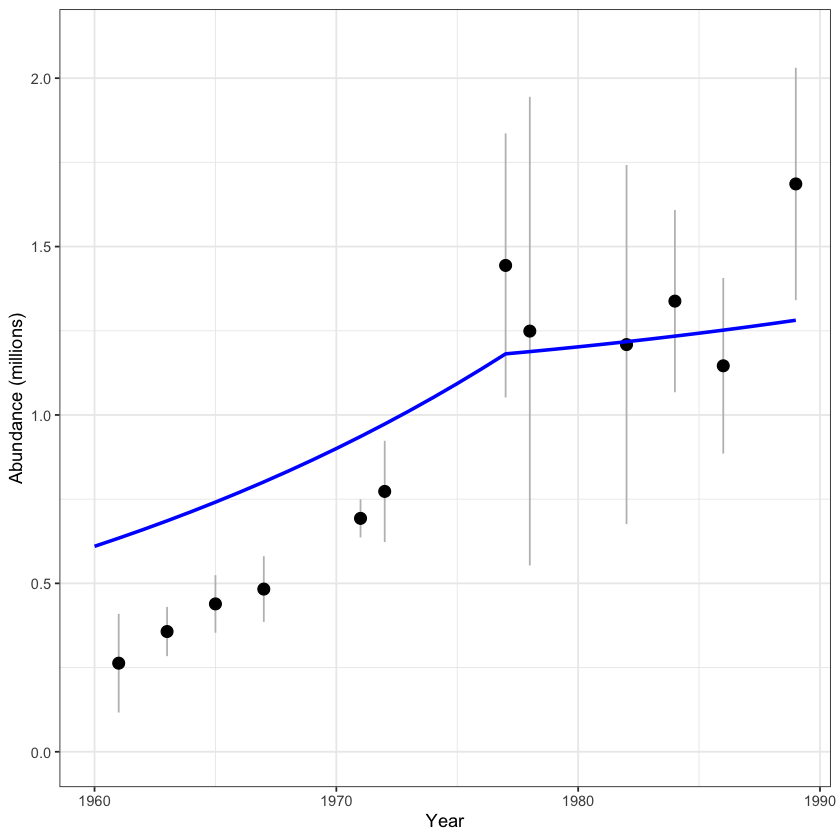

In [5]:
#create a new dataframe that has the projections added
tmp_wilde <- data.frame(Nhat = wildebeest$Nhat,
                        Nproj = test_proj,
                        Year = wildebeest$year,
                        lci = wildebeest$lci,
                        uci = wildebeest$uci)

#plot the projections and the estimates
ggplot(tmp_wilde, aes(x=Year, y=Nproj)) +
  geom_errorbar(aes(ymin=lci,ymax=uci), width=0, color="grey") +
  geom_point(aes(x=Year,y=Nhat), size=3) +
  geom_line(aes(x=Year,y=Nproj),color="blue", size=1) +
  ylim(0,2.1) + ylab("Abundance (millions)") +
  theme_bw()

In [6]:
logistic_nll <- function(pars,years,removals, Nhat, SEhat){
  #parameter set up
  N0 <- exp(pars[1])
  r <- exp(pars[2])
  k <- exp(pars[3])
  N <- numeric(years)
  N[1] <- N0
  
  #generate population dynamics:
  for(i in 2:years){
    N[i]=N[i-1] + r * N[i-1] * (1 - N[i-1] / k) - removals[i-1]
  }
  
  #calculate the NEGATIVE LOG likelihood
  # - calculate the Log Lik for each value (dnorm())
  # - sum them up (sum(dnorm()))
  # - take the negative of the sum of the Log Likelihoods (-sum(dnorm()))
  
  negloglik <- -sum(dnorm(Nhat,N,SEhat, log=TRUE), na.rm=TRUE)
  
  #return the negative log likelihood 
  return(negloglik)
}

In [7]:
y <- nrow(wildebeest)
N0 <- log(0.1)              #100,000
r <- log(0.25)               #linear growth before removal
k <-  log(1.5)                #fluctuates around 1.25 in latter years
ca <- wildebeest$Catch        #hunting assumed fixed

logistic_nll(pars=c(N0, r, k), y, ca, wildebeest$Nhat, wildebeest$sehat)

[1] 8.751256

In [8]:
#use guesses as starting values
N0 <- log(0.1)
r <- log(0.25)
k <-  log(1.5)
pars <- c(N0,r,k)
fit <- optim(
    par = pars,                 #initial parameter vector
    fn = logistic_nll,          #the function to me minimizes
    years = nrow(wildebeest),   #\
    removals = wildebeest$Catch,# \
    Nhat = wildebeest$Nhat,     #  \
    SEhat = wildebeest$sehat)   #   \->arguments passed to 'fn'

In [9]:
exp(fit$par)

[1] 0.2637005 0.1116494 2.6038554

In [10]:
new_sd = c(rep(0.12, 15), rep(0.005, 15))
N0 <- log(0.1)
r <- log(0.25)
k <-  log(1.5)
pars <- c(N0,r,k)
fit <- optim(
    par = pars,                 #initial parameter vector
    fn = logistic_nll,          #the function to me minimizes
    years = nrow(wildebeest),   #\
    removals = wildebeest$Catch,# \
    Nhat = wildebeest$Nhat,     #  \
    SEhat = new_sd)   #   \->arguments passed to 'fn'

In [11]:
exp(fit$par)

[1]  0.61340330  0.04327939 96.94172616

In [12]:
rainK_nll <- function(pars, years, removals, Nhat, SEhat, rain){
  #parameter set up
  N0 <- exp(pars[1])
  r <- exp(pars[2])
  beta0 <- pars[3]   #not transformed |
  beta1 <- pars[4]   #not transformed |-> note extra parameter now
  N <- numeric(years)
  k <- numeric(years)
  N[1] <- N0
  k[1] <- NA #1st K not in the model 
  
  #generate population dynamics:
  for(i in 2:years){
    k[i] <- exp(beta0 + beta1*rain[i]) #link fn of the linear predictor 
    N[i]=N[i-1] + r * N[i-1] * (1-N[i-1]/k[i]) - removals[i-1]
  }
  
  #calculate the NEGATIVE LOG likelihood
  # - calculate the Log Lik for each value (dnorm())
  # - sum them up (sum(dnorm()))
  # - take the negative of the sum of the Log Likelihoods (-sum(dnorm()))
  
  negloglik <- -sum(dnorm(Nhat,N,SEhat, log=TRUE), na.rm=TRUE)
  
  #return the negative log likelihood 
  return(negloglik)
}

In [13]:
get_yearly_growth = function(N0, r, beta0, beta1, years, removals, rain) {
    N = numeric(years)
    k = numeric(years)
    
    N[1] = N0
    k[1] = NA
    
    for(i in 2:years) {
        k[i] = exp(beta0 + beta1 * rain[i])
        N[i] = N[i-1] + r * N[i-1] * (1 - N[i-1] / k[i]) - removals[i]
    }
    return (list(N=N, rain=k))
}

In [27]:
N0 <- log(0.1)
r <- log(0.25)
beta0 <-  log(1.5)   #previous value
beta1 <-  0          #no effect

pars_rain <- c(N0,r,beta0,beta1)
fit_rainK <- optim(
    par = pars_rain,
    fn = rainK_nll,
    years = nrow(wildebeest), 
    removals = wildebeest$Catch,
    Nhat = wildebeest$Nhat,
    SEhat = wildebeest$sehat,
    rain = wildebeest$rain
)

In [15]:
print(paste("N0", exp(fit_rainK$par[1])))
print(paste("r", exp(fit_rainK$par[2])))
print(paste("beta0", fit_rainK$par[3]))
print(paste("beta1", fit_rainK$par[4]))


[1] "N0 0.268376029602748"
[1] "r 0.11761667840876"
[1] "beta0 -0.555231783349098"
[1] "beta1 1.04474983914937"


In [16]:
y = nrow(wildebeest)
growth = get_yearly_growth(
    exp(fit_rainK$par[1]),
    exp(fit_rainK$par[2]),
    fit_rainK$par[3],
    fit_rainK$par[4],
    y,
    wildebeest$Catch,
    wildebeest$rain
)

Warning message:
“Removed 18 rows containing missing values (geom_point).”


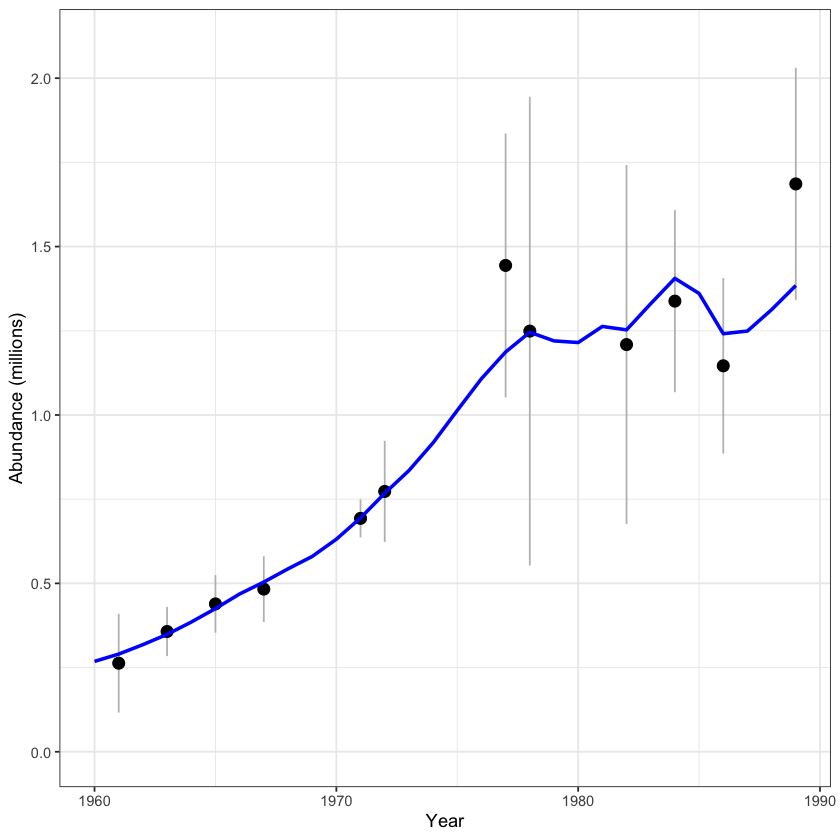

In [17]:
#create a new dataframe that has the projections added
tmp_wilde <- data.frame(Nhat = wildebeest$Nhat,
                        Nproj = growth$N,
                        Year = wildebeest$year,
                        lci = wildebeest$lci,
                        uci = wildebeest$uci)

#plot the projections and the estimates
ggplot(tmp_wilde, aes(x=Year, y=Nproj)) +
  geom_errorbar(aes(ymin=lci,ymax=uci), width=0, color="grey") +
  geom_point(aes(x=Year,y=Nhat), size=3) +
  geom_line(aes(x=Year,y=Nproj),color="blue", size=1) +
  ylim(0,2.1) + ylab("Abundance (millions)") +
  theme_bw()

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


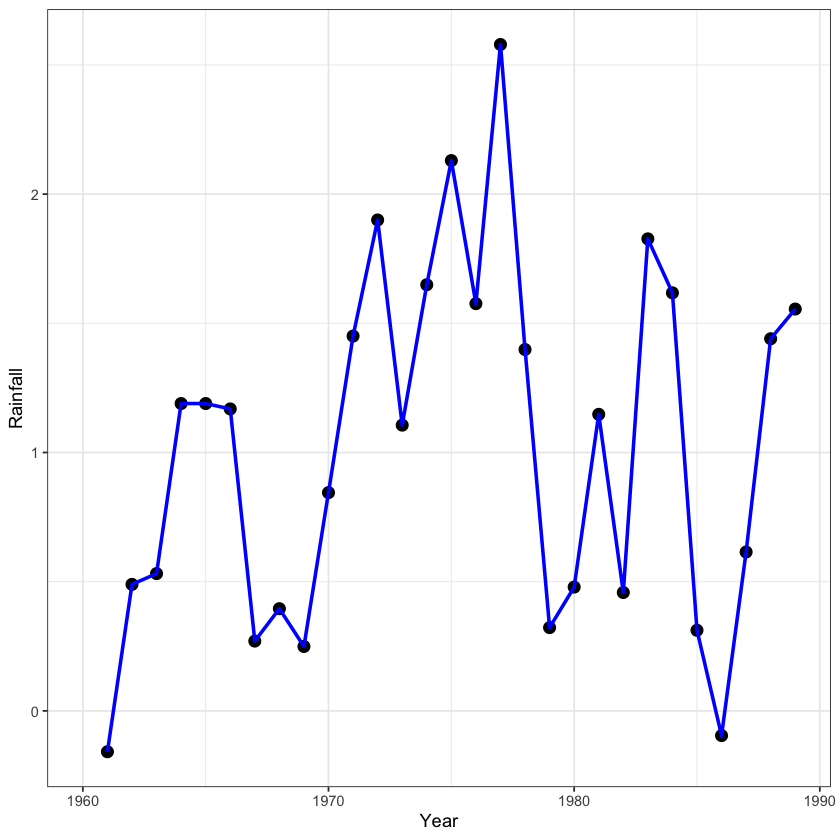

In [18]:
tmp_wilde <- data.frame(
    Rain = log(growth$rain),
    Year = wildebeest$year
)

ggplot(tmp_wilde, aes(x=Year, y=Rain)) +
  geom_point(aes(x=Year,y=Rain), size=3) +
  geom_line(aes(x=Year,y=Rain),color="blue", size=1) + 
  ylab("Rainfall") +
  theme_bw()

### Calculate AIC for the two models

In [44]:
N0 <- log(0.1)
r <- log(0.25)
k <-  log(1.5)
pars <- c(N0,r,k)
logistic_fit <- optim(
    par = pars,                 #initial parameter vector
    fn = logistic_nll,          #the function to me minimizes
    years = nrow(wildebeest),   #\
    removals = wildebeest$Catch,# \
    Nhat = wildebeest$Nhat,     #  \
    SEhat = wildebeest$sehat)   #   \->arguments passed to 'fn'

K_logist <- length(logistic_fit$par)
AIC_logistic = 2 * K_logist - 2 * logistic_fit$value

rain_fit <- optim(
    par = pars_rain,
    fn = rainK_nll,
    years = nrow(wildebeest), 
    removals = wildebeest$Catch,
    Nhat = wildebeest$Nhat,
    SEhat = wildebeest$sehat,
    rain = wildebeest$rain
)

K_rain = length(rain_fit$par)
AIC_rain = 2 * K_rain - 2 * rain_fit$value

data.frame(Model = c("logistic","rainK"),
    K = c(K_logist, K_rain),
    nll = c(logistic_fit$value, rain_fit$value),
    AIC = c(AIC_logistic, AIC_rain),
    dAIC = c(AIC_logistic, AIC_rain)- min(c(AIC_logistic, AIC_rain)))

Model,K,nll,AIC,dAIC
<chr>,<int>,<dbl>,<dbl>,<dbl>
logistic,3,-12.54118,31.08236,0.000000
rainK,4,-13.99331,35.98662,4.904266


In [46]:
logistic_fit

$par
[1] -1.3329413 -2.1923918  0.9569932

$value
[1] -12.54118

$counts
function gradient 
     142       NA 

$convergence
[1] 0

$message
NULL